In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install pycaret

In [ ]:
# Define the digits to load
digits = list(range(10))

# Load all CSV files and concatenate into a single dataframe
data = []
for digit in digits:
    df = pd.read_excel(f"features_{digit}.xlsx")
    df['label'] = digit  # Add a column for the digit label
    data.append(df)
# Concatenate all dataframes
data = pd.concat(data, ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HuMoment_1   200 non-null    float64
 1   HuMoment_2   200 non-null    float64
 2   HuMoment_3   200 non-null    float64
 3   HuMoment_4   200 non-null    float64
 4   HuMoment_5   200 non-null    float64
 5   HuMoment_6   200 non-null    float64
 6   HuMoment_7   200 non-null    float64
 7   EulerNumber  200 non-null    int64  
 8   Area         200 non-null    int64  
 9   label        200 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 15.8 KB


In [ ]:

from pycaret.classification import *
f_setup = setup(data=data, target='label', session_id=42)

# Compare all models and select the best one based on accuracy
best_model = compare_models()
print("Best model:", best_model)

,Description,Value
0,Session id,42
1,Target,label
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8"
4,Original data shape,"(180, 10)"
5,Transformed data shape,"(180, 10)"
6,Transformed train set shape,"(125, 10)"
7,Transformed test set shape,"(55, 10)"
8,Numeric features,9
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8962,0.9935,0.8962,0.8871,0.8796,0.8820,0.8890,0.7070
lda,Linear Discriminant Analysis,0.8878,0.0000,0.8878,0.9033,0.8751,0.8728,0.8826,0.0290
rf,Random Forest Classifier,0.8481,0.9848,0.8481,0.8400,0.8296,0.8269,0.8359,0.2150
et,Extra Trees Classifier,0.8410,0.9825,0.8410,0.8249,0.8172,0.8187,0.8289,0.1620
xgboost,Extreme Gradient Boosting,0.8231,0.9850,0.8231,0.8388,0.8075,0.7988,0.8085,0.1200
dt,Decision Tree Classifier,0.8160,0.8976,0.8160,0.8171,0.7986,0.7906,0.7994,0.0620
gbc,Gradient Boosting Classifier,0.8141,0.0000,0.8141,0.8191,0.7969,0.7877,0.7978,1.0910
nb,Naive Bayes,0.7103,0.9637,0.7103,0.6577,0.6518,0.6709,0.6918,0.0580
lr,Logistic Regression,0.6859,0.0000,0.6859,0.6651,0.6431,0.6427,0.6589,0.6310
knn,K Neighbors Classifier,0.5436,0.8784,0.5436,0.5417,0.5052,0.4875,0.5061,0.0820


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Best model: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Split the data into features (X) and target (y)
X = data.drop(columns=['label'])
y = data['label']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (LightGBM can handle unscaled data, but scaling can still help)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Create LightGBM datasets for training
train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)

# Set parameters for the model
params = {
    'objective': 'multiclass',
    'num_class': 10,  # We have 10 classes (digits 0-9)
    'metric': 'multi_logloss',  # Multi-class logarithmic loss as evaluation metric
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # Number of leaves in one tree
    'learning_rate': 0.05,  # Learning rate
    'feature_fraction': 0.9  # Fraction of features to use for training
}

# Train the model
lgb_model = lgb.train(params, train_data, valid_sets=[test_data])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 9
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.130735
[LightGBM] [Info] Start training from score -2.241960
[LightGBM] [Info] Start training from score -2.677279
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.184802
[LightGBM] [Info] Start training from score -2.436116
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.367124
[LightGBM] [Info] Start training from score -2.184802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
# Make predictions on the test set
y_pred = lgb_model.predict(X_test_scaled, num_iteration=lgb_model.best_iteration)
y_pred = [np.argmax(pred) for pred in y_pred]  # Convert probabilities to class labels

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         1
           2       1.00      0.67      0.80         3
           3       1.00      0.78      0.88         9
           4       0.75      0.75      0.75         4
           5       1.00      1.00      1.00         2
           6       0.86      1.00      0.92         6
           7       0.67      1.00      0.80         4
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         2

    accuracy                           0.90        40
   macro avg       0.93      0.92      0.91        40
weighted avg       0.92      0.90      0.90        40

Confusion Matrix:
[[4 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 1 0 0]
 [0 0 0 7 1 0 1 0 0 0]
 [0 0 0 0 3 0 0 1 0 0]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 

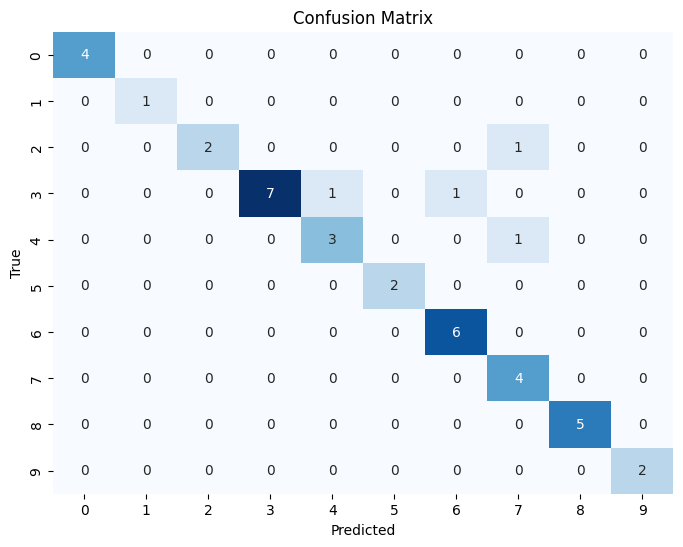

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
df = pd.read_excel(f"features_numeros.xlsx")
df_scaled = scaler.fit_transform(df)

# Concatenate all dataframes
print(df_scaled)
y_pred = lgb_model.predict(df_scaled, num_iteration=lgb_model.best_iteration)
y_pred = [np.argmax(pred) for pred in y_pred]  # Convert probabilities to class labels

[[ 0.97532698 -0.98007442 -1.3488862  -1.02464139 -0.65710082 -0.69167493
   0.84952374  0.         -1.00343559]
 [ 1.03525438  1.56879601 -0.18935368  0.33306157 -0.0266      0.96642461
  -0.795664    0.         -1.12886504]
 [-0.11105172 -0.93562903  1.07639718 -0.60184138 -0.43383299 -0.34357298
   0.55733379  0.          0.81529142]
 [-0.75476937  0.12457018 -0.33200203 -0.81624186 -0.69205468 -1.0051889
   1.05996794  0.          0.87800614]
 [ 1.01266224  1.70724537  0.97776869 -0.11125934 -0.85679529 -1.19376605
  -1.20971657  0.         -0.62714725]
 [ 0.1021167  -0.50681173 -1.51329415 -0.80466178 -0.65300512 -0.46888149
   0.84804604  0.          1.75601229]
 [-0.17942626 -0.35205797  1.27545986  0.97717226  1.32008069  1.18180681
   0.38715081  0.         -0.87800614]
 [-2.08011296 -0.62603842  0.05391034  2.04841191  1.99930821  1.55485292
  -1.69664174  0.          0.18814417]]


In [ ]:
print(y_pred)

[0, 1, 4, 7, 4, 0, 1, 4]


In [ ]:
import cv2
import numpy as np

def load_and_segment_images(image_files):
    digit_images = []
    all_areas = []

    # Primera pasada: calcular las áreas de todos los componentes
    for file in image_files:
        # Leer la imagen en escala de grises
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        _, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Encontrar contornos
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            area = cv2.contourArea(contour)
            all_areas.append(area)

    # Calcular el área promedio y definir los umbrales
    area_promedio = np.mean(all_areas)
    umbral_min = area_promedio * 0.2  # Ajusta el factor según tus necesidades
    umbral_max = area_promedio * 10

    # Segunda pasada: segmentar, filtrar por área y ordenar de izquierda a derecha
    for file in image_files:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        _, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filtrar contornos por área y ordenar por la coordenada x
        filtered_contours = [contour for contour in contours if umbral_min <= cv2.contourArea(contour) <= umbral_max]
        filtered_contours.sort(key=lambda contour: cv2.boundingRect(contour)[0])  # Ordenar por la coordenada x

        # Extraer los dígitos en el orden correcto
        for contour in filtered_contours:
            x, y, w, h = cv2.boundingRect(contour)
            digit = img[y:y+h, x:x+w]
            digit = cv2.resize(digit, (28, 28))  # Redimensionar a 28x28 píxeles
            digit_images.append(digit)

    digit_images = np.array(digit_images)
    digit_images = digit_images / 255.0  # Normalizar los valores de píxel a [0, 1]
    return digit_images

# Suponiendo que tienes una lista de archivos de imagen
image_files = ["d0.jpg", "d1.jpg", "d2.jpg", "d3.jpg", "d4.jpg", "d5.jpg", "d6.jpg", "d7.jpg", "d8.jpg", "d9.jpg"]
digit_images = load_and_segment_images(image_files)


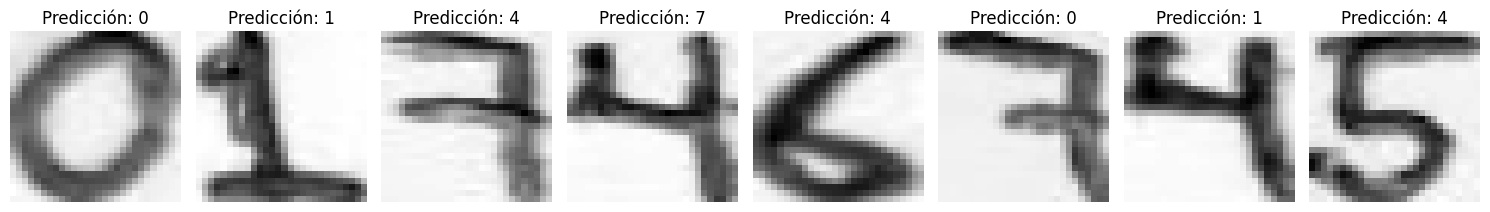

In [ ]:
# Número de imágenes a mostrar
num_imagenes = 8  # Cambia este número para mostrar más o menos imágenes
id_images = load_and_segment_images(["id.jpg"])
# Crear subplots
fig, axes = plt.subplots(1, num_imagenes, figsize=(15, 3))  # 1 fila y 'num_imagenes' columnas
#for i in range(num_imagenes):
axes[0].imshow(id_images[0].reshape(28, 28), cmap='gray')
axes[0].set_title(f"Predicción: {y_pred[0]}")
axes[0].axis('off')  # Ocultar los ejes

axes[1].imshow(id_images[3].reshape(28, 28), cmap='gray')
axes[1].set_title(f"Predicción: {y_pred[1]}")
axes[1].axis('off')  # Ocultar los ejes

axes[2].imshow(id_images[1].reshape(28, 28), cmap='gray')
axes[2].set_title(f"Predicción: {y_pred[2]}")
axes[2].axis('off')  # Ocultar los ejes

axes[3].imshow(id_images[2].reshape(28, 28), cmap='gray')
axes[3].set_title(f"Predicción: {y_pred[3]}")
axes[3].axis('off')  # Ocultar los ejes

axes[4].imshow(id_images[7].reshape(28, 28), cmap='gray')
axes[4].set_title(f"Predicción: {y_pred[4]}")
axes[4].axis('off')  # Ocultar los ejes


axes[5].imshow(id_images[4].reshape(28, 28), cmap='gray')
axes[5].set_title(f"Predicción: {y_pred[5]}")
axes[5].axis('off')  # Ocultar los ejes


axes[6].imshow(id_images[6].reshape(28, 28), cmap='gray')
axes[6].set_title(f"Predicción: {y_pred[6]}")
axes[6].axis('off')  # Ocultar los ejes


axes[7].imshow(id_images[5].reshape(28, 28), cmap='gray')
axes[7].set_title(f"Predicción: {y_pred[7]}")
axes[7].axis('off')  # Ocultar los ejes




plt.tight_layout()  # Ajustar el espacio entre las imágenes
plt.show()